# EDA of NYC High Volume FHV Trips

**Course:** NYU – Data Science (Final Project)  
**Focus of this notebook:** Step 2 – EDA    
**Author:** Desmond Peng, harvey Yang

---

## Goal of Step 2

**Big question for Step 2:**

> When price change, will demand change accordingly?

We will:
1. Observe the changes in ride demand on different days of the week and at different times.
2. Observe the ride-hailing demand and price per mile in different boroughs.
3. Observe the relationship between different price levels and the demand for rides.
4. Calculate **Regional Resilience Index**. A positive value indicates that the region has stronger demand relative to its price level.



In [ ]:
# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import plotly.express as px

# Load dataset
df = pd.read_csv("../data/processed/dataset.csv")

# Load taxi zone shapefile
taxi_zones = gpd.read_file("../data/taxi_zones/taxi_zones.shp")

In [3]:
# Data preprocessing and feature engineering
# Total revenue calculation
df['total_revenue'] = (df['base_passenger_fare'] + df['tolls'] + df['bcf'] +
                       df['congestion_surcharge'] + df['airport_fee'] + df['tips'])

# Revenue per mile
df['revenue_per_mile'] = df['total_revenue'] / df['trip_miles']
df['revenue_per_mile'] = df['revenue_per_mile'].replace([np.inf, -np.inf], np.nan)
# Drop rows with NaN values
df = df.dropna(subset=['revenue_per_mile'])

# Revenue per second
df['revenue_per_second'] = df['total_revenue'] / df['trip_time']
df['revenue_per_second'] = df['revenue_per_second'].replace([np.inf, -np.inf], np.nan)
# Drop rows with NaN values
df = df.dropna(subset=['revenue_per_second'])

# Extract datetime features
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df['pickup_hour'] = df['pickup_datetime'].dt.hour
df['pickup_dayofweek'] = df['pickup_datetime'].dt.dayofweek # 0=Monday, 6=Sunday
df['pickup_month'] = df['pickup_datetime'].dt.month
df['pickup_date'] = df['pickup_datetime'].dt.date

# Show the corresponding percentiles of revenue_per_mile for each PULocationID, pickup_hour, pickup_dayofweek group
GROUP_KEYS = ['PULocationID', 'pickup_hour', 'pickup_dayofweek']
df['percentile_rank'] = df.groupby(GROUP_KEYS)['revenue_per_mile'].transform(lambda x: x.rank(pct=True))

In [5]:
# Merge dataframe with taxi zones shapefile to get zone information
df = taxi_zones.merge(df, left_on='LocationID', right_on='PULocationID', how='right')

In [6]:
df.head()

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry,PULocationID,DOLocationID,pickup_datetime,...,airport_fee,tips,total_revenue,revenue_per_mile,revenue_per_second,pickup_hour,pickup_dayofweek,pickup_month,pickup_date,percentile_rank
0,188.0,0.097798,0.000313,Prospect-Lefferts Gardens,188.0,Brooklyn,"POLYGON ((996098.526 181302.644, 996121.518 18...",188,39,2024-01-01 00:00:59,...,0.0,10.0,27.48,8.259693,0.026836,0,0,1,2024-01-01,0.855995
1,76.0,0.241203,0.001267,East New York,76.0,Brooklyn,"POLYGON ((1017356.842 186741.461, 1017363.873 ...",76,77,2024-01-01 00:53:41,...,0.0,0.0,19.32,15.901235,0.030863,0,0,1,2024-01-01,0.992708
2,90.0,0.030759,0.000055,Flatiron,90.0,Manhattan,"POLYGON ((985265.129 208165.863, 985125.733 20...",90,249,2024-01-01 00:33:55,...,0.0,0.0,12.14,8.489510,0.010888,0,0,1,2024-01-01,0.622070
3,157.0,0.131300,0.000354,Maspeth,157.0,Queens,"POLYGON ((1012564.178 207131.843, 1012819.309 ...",157,82,2024-01-01 00:06:26,...,0.0,0.0,18.34,5.916129,0.017858,0,0,1,2024-01-01,0.491870
4,56.0,0.056848,0.000181,Corona,56.0,Queens,"POLYGON ((1024813.399 211643.796, 1024910.997 ...",56,75,2024-01-01 00:42:58,...,0.0,0.0,34.91,3.729701,0.025079,0,0,1,2024-01-01,0.290795


# Q2-1 - Observe the changes in ride demand on different days of the week and at different times.
Use a pivot table to count the number of pickups for each hour and day of the week. Plot heatmap using seaborn library.

Based on the heatmap, we found that:
1. The highest demand is during weekday rush hours (8-9 AM and 5-6 PM), with Fridays showing the highest overall demand. 
2. Fridays and Saturdays have higher demand in the evenings compared to other days.

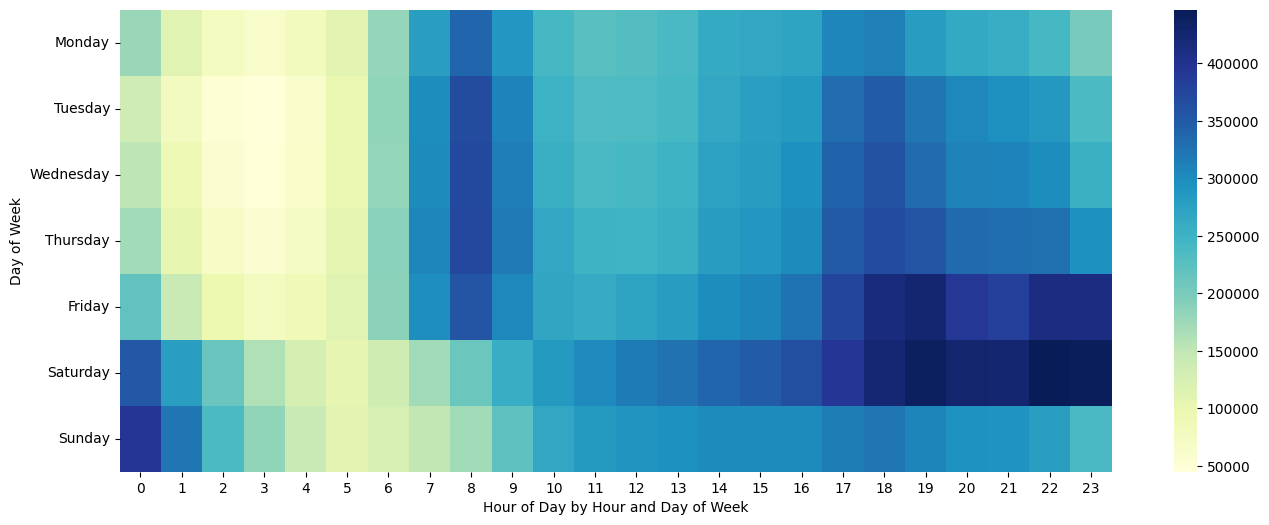

In [ ]:
# Heatmap of pickup times by hours and days of the week
pickup_heatmap = df.pivot_table(index='pickup_dayofweek', columns='pickup_hour', values='total_revenue', aggfunc='count', fill_value=0)
plt.figure(figsize=(16, 6))
sns.heatmap(pickup_heatmap, cmap='YlGnBu', annot=False, fmt='d')
# plt.title('Pickup Times Heatmap')

# Set yaxis labels to day names
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
plt.yticks(ticks=np.arange(7)+0.5, labels=day_names, rotation=0)
plt.xlabel('Hour of Day by Hour and Day of Week')
plt.ylabel('Day of Week')
plt.show()

# Q2-2 - Observe the ride-hailing demand and price per mile in different boroughs.
Draw geo map based on two features: Average revenue per mile and pickup times.

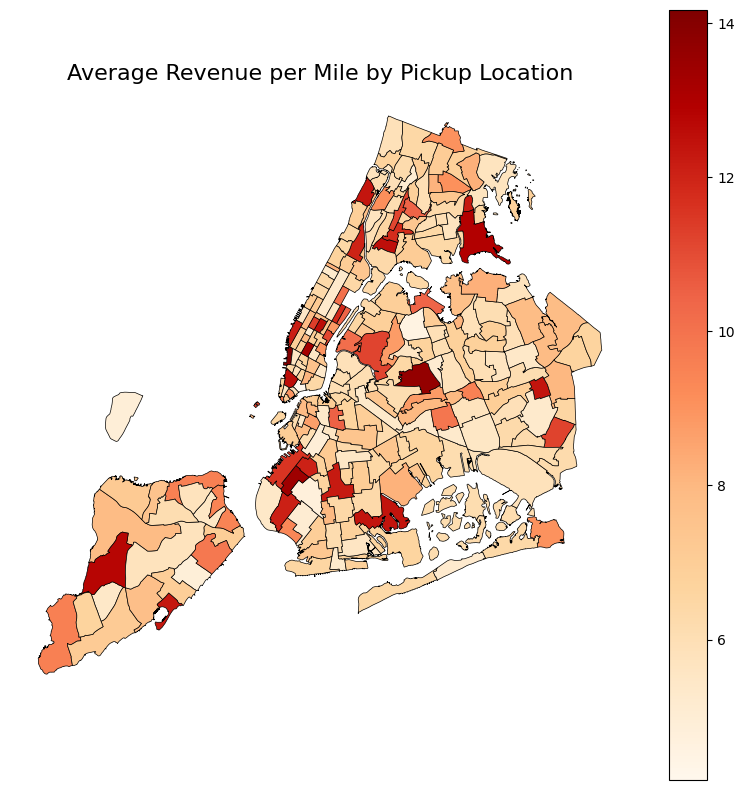

In [ ]:
# Highest revenue zones
high_revenue_zones = df.groupby('PULocationID')['revenue_per_mile'].mean().reset_index()

# Transform to GeoDataFrame without merge with taxi_zones
high_revenue_zones = gpd.GeoDataFrame(high_revenue_zones, geometry=taxi_zones.geometry)

# Plotting the revenue per mile by pickup location
high_revenue_zones.plot(column='revenue_per_mile', cmap='OrRd', legend=True, figsize=(10, 10), edgecolor='black', linewidth=0.5)
plt.title('Average Revenue per Mile by Pickup Location', fontsize=16)
plt.axis('off')
plt.show()

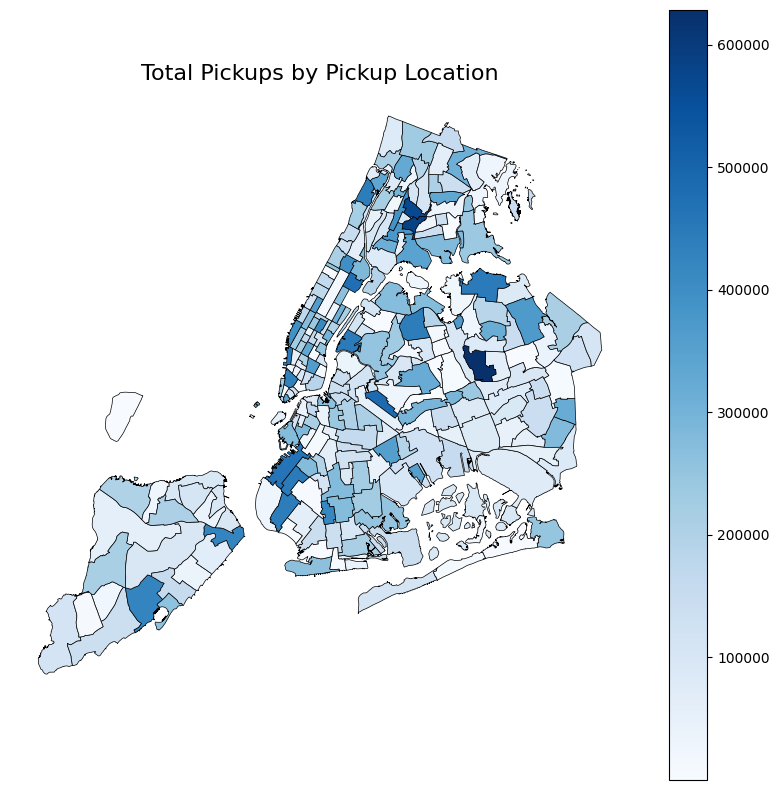

In [34]:
# Highest pickup times zones
high_pickup_zones = df.groupby('PULocationID')['total_revenue'].count().reset_index()

# Transform to GeoDataFrame without merge with taxi_zones
result_pickup = gpd.GeoDataFrame(high_pickup_zones, geometry=taxi_zones.geometry)

# Plotting the total pickups by pickup location
result_pickup.plot(column='total_revenue', cmap='Blues', legend=True, figsize=(10, 10), edgecolor='black', linewidth=0.5)
plt.title('Total Pickups by Pickup Location', fontsize=16)
plt.axis('off')
plt.show()

/var/folders/3c/kxfpvzq56558my2fcggnzrn40000gn/T/ipykernel_58326/3209790967.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=borough_revenue, y='borough', x='total_revenue', palette='OrRd')


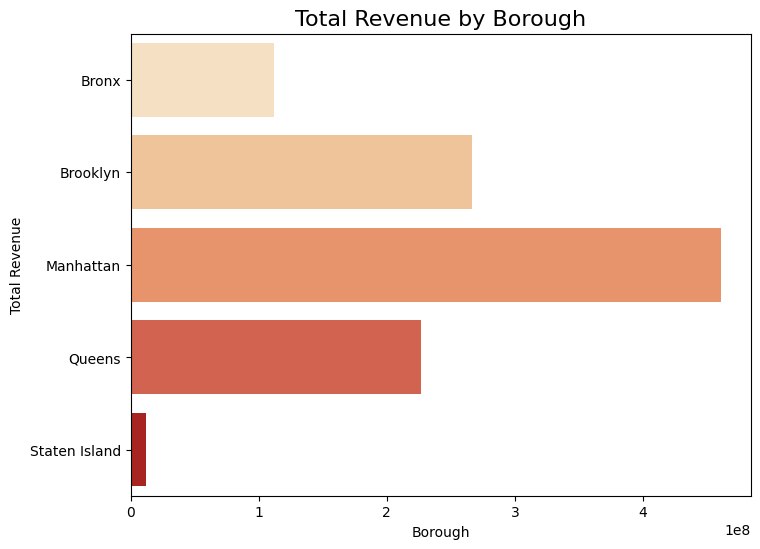

In [36]:
# Revenue percentage by borough
borough_revenue = df.groupby('borough')['total_revenue'].sum().reset_index()

# Bar chart of average revenue per mile by borough
plt.figure(figsize=(8, 6))
sns.barplot(data=borough_revenue, y='borough', x='total_revenue', palette='OrRd')
plt.title('Total Revenue by Borough', fontsize=16)
plt.ylabel('Total Revenue')
plt.xlabel('Borough')
plt.show()

/var/folders/3c/kxfpvzq56558my2fcggnzrn40000gn/T/ipykernel_58326/2650571868.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=borough_pickups, y='borough', x='total_revenue', palette='Blues')


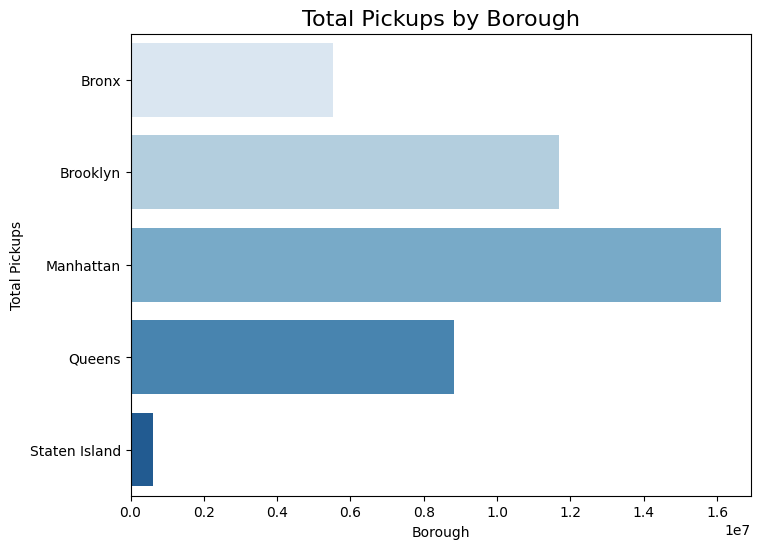

In [37]:
# Total pickups by borough
borough_pickups = df.groupby('borough')['total_revenue'].count().reset_index() 
# Bar chart of total pickups by borough
plt.figure(figsize=(8, 6))
sns.barplot(data=borough_pickups, y='borough', x='total_revenue', palette='Blues')
plt.title('Total Pickups by Borough', fontsize=16)
plt.ylabel('Total Pickups')
plt.xlabel('Borough')
plt.show()

# Q2-3 - Observe the relationship between different price levels and the demand for rides.
Calculate daily average price percentile and transaction count for each PULocationID, pickup_hour, pickup_dayofweek group
1. Group by PULocationID, pickup_hour, pickup_dayofweek, pickup_date
2. Aggregate to get mean of percentile_rank and count of trip_miles
3. Merge back to get borough information
4. Plot time series for 6 boroughs

In [ ]:
# Daily aggregation of average price percentile and transaction count
aggregation_functions = {
    'percentile_rank': 'mean',
    'trip_miles': 'count'  
}

result_df = df.groupby(GROUP_KEYS + ['pickup_date']).agg(aggregation_functions)

# Rename columns for better readability
result_df = result_df.rename(columns={
    'percentile_rank': 'avg_price_percentile',
    'trip_miles': 'transaction_count'
}).reset_index()

result_df.head()

,PULocationID,pickup_hour,pickup_dayofweek,pickup_date,avg_price_percentile,transaction_count
0,2,0,6,2024-03-10,1.0,1
1,2,6,5,2024-07-06,1.0,1
2,2,7,5,2024-08-03,1.0,1
3,2,8,4,2024-03-22,1.0,1
4,2,8,4,2024-04-19,0.5,1


In [41]:
# Merge with taxi zones to get borough names
result_df = result_df.merge(taxi_zones[['LocationID', 'borough']], left_on='PULocationID', right_on='LocationID', how='left')

result_df.head()

,PULocationID,pickup_hour,pickup_dayofweek,pickup_date,avg_price_percentile,transaction_count,LocationID,borough
0,2,0,6,2024-03-10,1.0,1,2.0,Queens
1,2,6,5,2024-07-06,1.0,1,2.0,Queens
2,2,7,5,2024-08-03,1.0,1,2.0,Queens
3,2,8,4,2024-03-22,1.0,1,2.0,Queens
4,2,8,4,2024-04-19,0.5,1,2.0,Queens


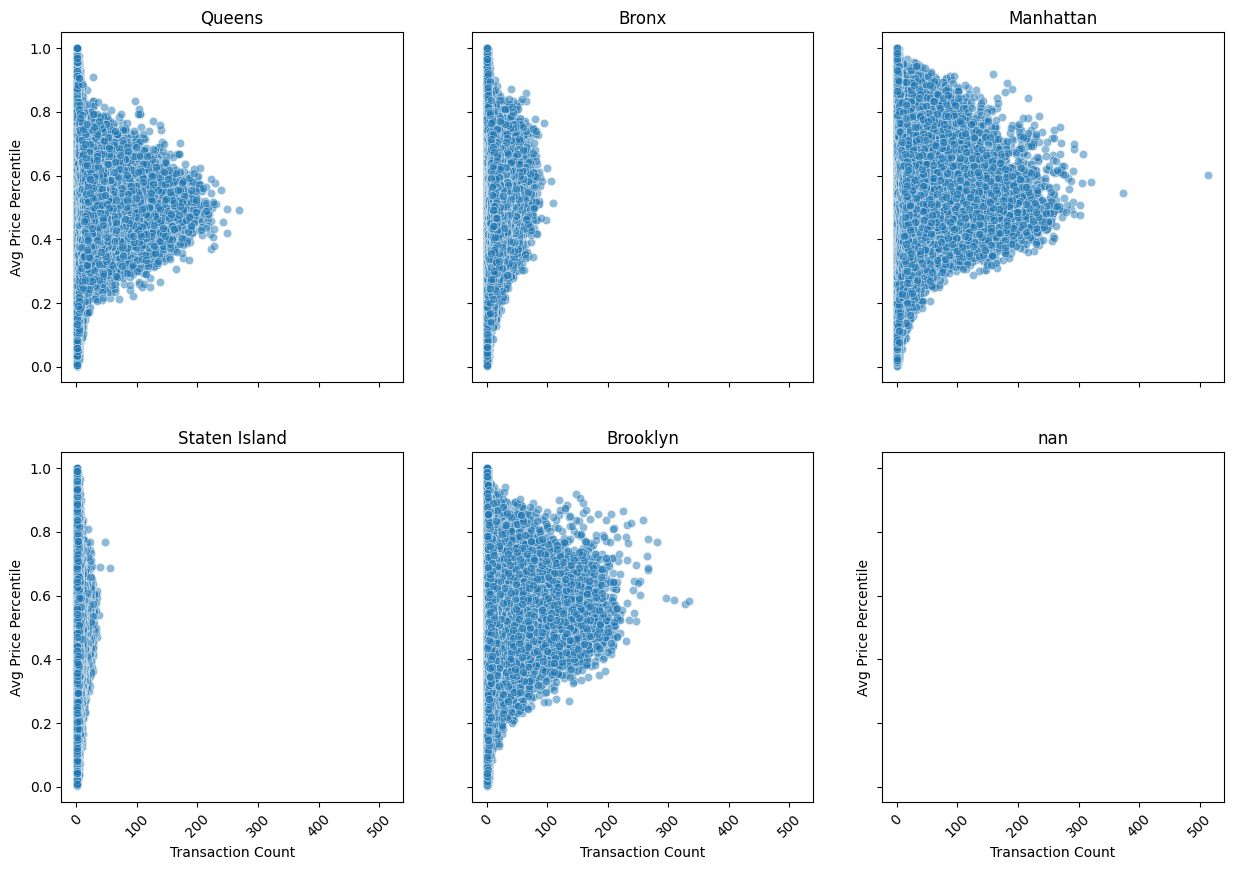

In [45]:
# Subplot for 6 boroughs for scatter plot
boroughs = result_df['borough'].unique()

fig, axes = plt.subplots(2, 3, figsize=(15, 10), sharex=True, sharey=True)
axes = axes.flatten()
for i, borough in enumerate(boroughs):
    ax = axes[i]
    borough_data = result_df[result_df['borough'] == borough]
    # Seaborn scatter plot with size based on transaction count
    sns.scatterplot(data=borough_data, x='transaction_count', y='avg_price_percentile', alpha=0.5, ax=ax)
    ax.set_title(f'{borough}')
    ax.set_xlabel('Transaction Count')
    ax.set_ylabel('Avg Price Percentile')
    ax.tick_params(axis='x', rotation=45)

# Q2-4 - Calculate **Regional Resilience Index**. A positive value indicates that the region has stronger demand relative to its price level.
To calculate resilience index:
1. Calculate average price percentile and transaction count for each PULocationID
2. Rank the price and demand metrics
3. Compute the resilience index as the difference between demand rank and price rank
4. Positive value indicates stronger demand relative to price level
5. List the top 10 regions based on resilience index

In [ ]:
# Resilience index calculation
regional_stats = result_df.groupby('PULocationID').agg({
    'avg_price_percentile': 'mean',
    'transaction_count': 'mean'
}).reset_index()

# Scale across regions
regional_stats['price_rank'] = regional_stats['avg_price_percentile'].rank(pct=True)
regional_stats['demand_rank'] = regional_stats['transaction_count'].rank(pct=True)

# Resilience index = Demand Rank - Price Rank
regional_stats['regional_resilience'] = regional_stats['demand_rank'] - regional_stats['price_rank']
regional_stats.head()

,PULocationID,avg_price_percentile,transaction_count,price_rank,demand_rank,regional_resilience
0,2,0.811380,1.043011,0.988506,0.015326,-0.973180
1,3,0.499967,10.955432,0.739464,0.367816,-0.371648
2,4,0.497089,15.917304,0.180077,0.517241,0.337165
3,5,0.506803,2.063021,0.904215,0.091954,-0.812261
4,6,0.503781,3.167657,0.873563,0.114943,-0.758621


In [47]:
# Merge
r = regional_stats.merge(taxi_zones, left_on='PULocationID', right_on='LocationID', how='left')
r.columns

Index(['PULocationID', 'avg_price_percentile', 'transaction_count',
       'price_rank', 'demand_rank', 'regional_resilience', 'OBJECTID',
       'Shape_Leng', 'Shape_Area', 'zone', 'LocationID', 'borough',
       'geometry'],
      dtype='object')

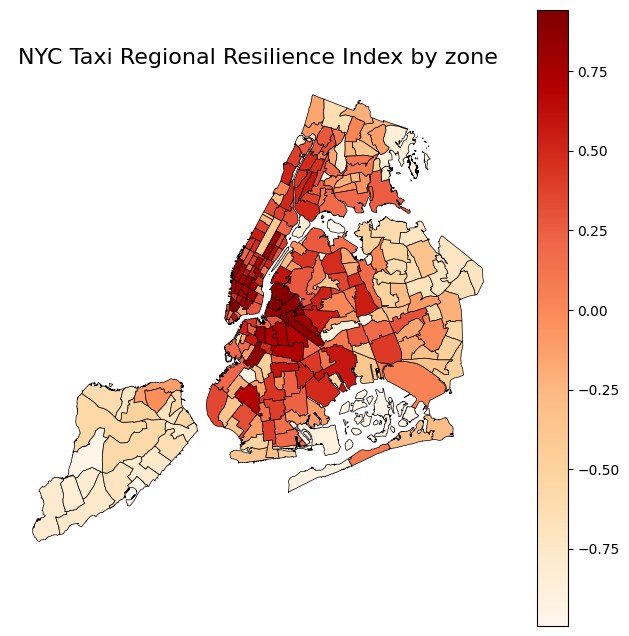

In [ ]:
# Merge
r = taxi_zones.merge(regional_stats, left_on='LocationID', right_on='PULocationID', how='left')

# Plotting the resilience index on a map
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
r.plot(
    ax=ax,
    column='regional_resilience',
    legend=True,
    cmap='OrRd',
    edgecolor='black',
    linewidth=0.5
)
ax.set_title("NYC Taxi Regional Resilience Index by zone", fontsize=16)
ax.set_axis_off()
plt.show()

In [ ]:
# Show zones with high resilience
r[r['regional_resilience'] > 0.85][['zone', 'borough', 'regional_resilience']]

,zone,borough,regional_resilience
36,Bushwick South,Brooklyn,0.869732
78,East Village,Manhattan,0.850575
79,East Williamsburg,Brooklyn,0.881226
111,Greenpoint,Brooklyn,0.904215
180,Park Slope,Brooklyn,0.865900
230,TriBeCa/Civic Center,Manhattan,0.942529
233,Union Sq,Manhattan,0.873563
245,West Chelsea/Hudson Yards,Manhattan,0.923372
254,Williamsburg (North Side),Brooklyn,0.904215
